# Red Neuronal para la predicción de acciones (LSTM)

In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

## Parámetros de estudio

In [3]:
num_dias_pred = 20
time_step = 100

## Función auxiliar para gráficas

In [4]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)], color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

## Lectura de los datos

In [6]:
!pip install yfinance


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/b2/38/7533745b517c34b7b749a7a21f631711354a3d4d39a840d75d20c94d71a0/yfinance-0.2.51-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/04/13/d9839089b900fa7b479cce495d62110cddc4bd5630a04d8469916c0e79c5/frozendict-2.4.6-py311-none-any.whl.metadata
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     - ------------------------------------- 30.7/948.2 kB 1.3 MB/s eta 0:00:01
     --- ----------------------------------- 92.2/948.2 kB 1.3 MB/s eta 0:00:01
     ------ ------------------------------- 174.1/948.2 kB 1.5 MB/s eta 0:00:01
     --------- ---------------------------- 225.3/

In [7]:
import yfinance as yf
dataset = yf.Ticker("A3M.MC").history(period="max")

 El dataset contiene información histórica del precio de la acción de una empresa cotizada en la Bolsa de Madrid, incluyendo precios de apertura, cierre, máximos, mínimos, volumen de negociación, dividendos y splits. Vamos a crear un modelo LSTM para predecir el precio máximo de las acciones de una empresa en los próximos 20 días, utilizando secuencias de 100 días previos como entrada. 

In [8]:
dataset.tail(11)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-19 00:00:00+01:00,4.360,4.470,4.350,4.400,615442,0.0,0.0
2024-12-20 00:00:00+01:00,4.365,4.375,4.300,4.340,586364,0.0,0.0
2024-12-23 00:00:00+01:00,4.340,4.340,4.280,4.335,296645,0.0,0.0
2024-12-24 00:00:00+01:00,4.320,4.345,4.305,4.310,95140,0.0,0.0
2024-12-27 00:00:00+01:00,4.325,4.390,4.310,4.370,252976,0.0,0.0
2024-12-30 00:00:00+01:00,4.370,4.380,4.325,4.360,247282,0.0,0.0
2024-12-31 00:00:00+01:00,4.335,4.390,4.335,4.370,176883,0.0,0.0
2025-01-02 00:00:00+01:00,4.370,4.480,4.370,4.470,301559,0.0,0.0
2025-01-03 00:00:00+01:00,4.490,4.520,4.450,4.480,247440,0.0,0.0


In [9]:
print(dataset.index.dtype)

datetime64[ns, Europe/Madrid]


In [10]:
dataset.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5428.000000,5428.000000,5428.000000,5428.000000,5.428000e+03,5428.000000,5428.000000
mean,3.632434,3.678521,3.577670,3.631287,7.006667e+05,0.001430,0.000737
std,1.556147,1.570332,1.538123,1.556224,1.251450e+06,0.019792,0.054293
min,1.115080,1.141450,1.100012,1.115080,0.000000e+00,0.000000,0.000000
25%,2.361454,2.397519,2.316805,2.359188,2.773835e+05,0.000000,0.000000
50%,3.098615,3.127723,3.051066,3.101192,4.756880e+05,0.000000,0.000000
75%,4.992155,5.037812,4.914747,4.992993,8.191410e+05,0.000000,0.000000
max,7.723192,7.767241,7.591047,7.669356,5.038508e+07,0.450000,4.000000


## Sets de entrenamiento y validación
La LSTM se entrenará con datos de desde hoy hace 12 años hasta hoy hace 10 años. La validación se hará con datos de los últimos 2 años.
En ambos sets sólo se usará el valor más alto de la acción para cada día

In [51]:
import datetime
fin_entrenamiento = dataset.index.max() - pd.DateOffset(years=2)
print(f"Fecha límite entre entrenamiento y validación = {fin_entrenamiento}")

set_entrenamiento = dataset[:fin_entrenamiento].iloc[:,1:2]
set_validacion = dataset[fin_entrenamiento:].iloc[:,1:2]

Fecha límite entre entrenamiento y validación = 2023-01-07 00:00:00+01:00


In [53]:
set_entrenamiento.shape

(4918, 1)

In [54]:
set_validacion.shape

(510, 1)

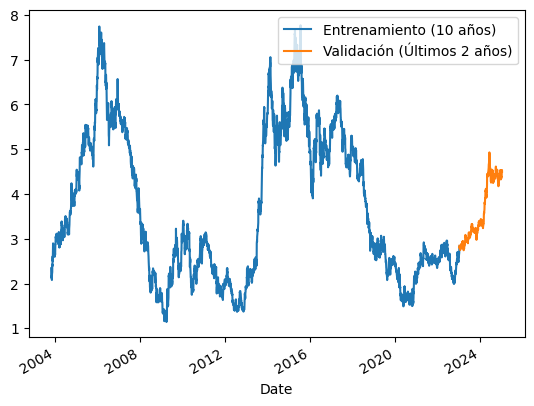

In [12]:
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)

plt.legend(['Entrenamiento (10 años)', 'Validación (Últimos 2 años)'])
plt.show()

## Normalización del set de entrenamiento

In [13]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [14]:
set_entrenamiento_escalado

array([[0.18116592],
       [0.16121468],
       [0.15819877],
       ...,
       [0.24527212],
       [0.25193119],
       [0.25513741]])

La red LSTM tendrá como entrada `time_step` datos consecutivos, y como salida `num_dias_pred` datos diarios (la predicción a partir de esos `time_step` datos). Se conformará de esta forma el set de entrenamiento


In [15]:
X_train_long_term = []
Y_train_long_term = []

In [16]:
for j in range(0, num_dias_pred):
    """Bucle para crear la tercera dimensión, que depende de los días a predecir"""
    X_train = []
    Y_train = []
    for i in range(0,len(set_entrenamiento_escalado)- num_dias_pred - time_step):
        """Bucle para crear la tabla para cada día de predicción"""
        # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
        X_train.append(set_entrenamiento_escalado[i:i+time_step,0])
        # Y: el siguiente dato
        indice = i+time_step+j
        Y_train.append(set_entrenamiento_escalado[indice:indice+1,0][0])
    X_train_long_term.append(X_train)
    Y_train_long_term.append(Y_train)

Esta celda sólo renombra las matrices para que el nombre sea más corto y las convierte de "lista de listas" a matriz de numpy.

La red neuronal ha de recibir los datos como matrices de numpy

In [17]:
X_train, Y_train = np.array(X_train_long_term), np.array(Y_train_long_term)

In [18]:
X_train.shape, Y_train.shape

((20, 4798, 100), (20, 4798))

El shape correcto (dimensiones de las matrices) es

En X: (días totales, time_step, num_dias_pred)
En Y: (días totales, num_dias_pred)

In [19]:
X_train = np.transpose(X_train, (1, 2, 0))

In [20]:
Y_train = np.transpose(Y_train, (1, 0))

In [21]:
print(f"En X: (días totales, {time_step}, {num_dias_pred}) En Y:(días totales, {num_dias_pred})")
X_train.shape, Y_train.shape

En X: (días totales, 100, 20) En Y:(días totales, 20)


((4798, 100, 20), (4798, 20))

Comprobación de que la colocación de los datos es coherente con la serie temporal aportada:<br>
- Para la matriz X

In [22]:
n = 0
print(f"Los {time_step} valores a partir del día {n} descargados de yfinance:")
print(set_entrenamiento_escalado[n:time_step + n,0])
print(f"Han de coincidir con la fila {n} de la matriz X_train")
print(list(X_train[n,:,0]))
set_entrenamiento_escalado[n:time_step + n,0] == list(X_train[n,:,0])

Los 100 valores a partir del día 0 descargados de yfinance:
[0.18116592 0.16121468 0.15819877 0.1536749  0.15239894 0.1478751
 0.14868714 0.15483487 0.14903508 0.14149541 0.15541491 0.16411461
 0.16376658 0.16817444 0.19415738 0.19079373 0.18835765 0.19891339
 0.21515288 0.22176462 0.20471325 0.21932867 0.23452419 0.26503104
 0.25679542 0.23603222 0.23243616 0.24183189 0.24020795 0.2240845
 0.23719204 0.239512   0.23951198 0.23603208 0.23533613 0.23487207
 0.22895633 0.23603213 0.23243622 0.22965241 0.22211265 0.22211265
 0.22211265 0.21979271 0.2330162  0.2330162  0.2330162  0.22628841
 0.22930443 0.22791249 0.24043995 0.25853523 0.26166727 0.26155127
 0.28243049 0.28127047 0.28753443 0.28475044 0.28359042 0.28127055
 0.27999461 0.28011064 0.28823028 0.28939021 0.28591044 0.28591032
 0.29727798 0.2914782  0.29461013 0.29403011 0.29635005 0.28962222
 0.29055025 0.29751004 0.29461015 0.29055025 0.29147818 0.28939023
 0.28544637 0.27419477 0.27233885 0.27547071 0.26851092 0.27280289
 0.2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

- Para la matriz Y

In [23]:
n = 0
print(f"Los {num_dias_pred} valores a partir del día {n} + el time_step = {time_step} descargados de yfinance son:")
print(set_entrenamiento_escalado[n + time_step:n + time_step + num_dias_pred,0])
print(f"Han de coincidir con la fila {n} de la matriz Y_train")
print(list(Y_train[n,:]))
set_entrenamiento_escalado[n + time_step:n + time_step + num_dias_pred,0] == Y_train[n,:]

Los 20 valores a partir del día 0 + el time_step = 100 descargados de yfinance son:
[0.27593483 0.25807123 0.26143527 0.25227143 0.26375521 0.26491511
 0.26735104 0.27431085 0.27755867 0.27871862 0.26537916 0.26271115
 0.26027533 0.2627112  0.26769903 0.26561107 0.26619099 0.26561102
 0.26561102 0.26561107]
Han de coincidir con la fila 0 de la matriz Y_train
[0.27593482558648547, 0.258071233582721, 0.2614352655803063, 0.25227143493926807, 0.26375520656724516, 0.26491511002118706, 0.2673510375949835, 0.2743108465835053, 0.27755867224063646, 0.2787186189304467, 0.2653791612156992, 0.2627111526946214, 0.26027533420366056, 0.26271119509665997, 0.26769903001122874, 0.2656110691062352, 0.2661909885575135, 0.26561101750589017, 0.26561101750589017, 0.2656110676987188]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

## Red LSTM

In [24]:
dim_entrada = (X_train.shape[1],num_dias_pred)
print(f"Dimensiones de la entrada {dim_entrada}")
dim_salida = num_dias_pred
na = 80

Dimensiones de la entrada (100, 20)


In [ ]:
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
# la salida es un vector de 20 valores, los 20 días que queremos predecir
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0182
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0025
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0023
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0020
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0019
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0019
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0019
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0018
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0018
Epoch 10/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0017
Epoch 11/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0017
Epoch 12/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0017
Epoch 13/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0018
Epoch 14/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0017
Epoch 15/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s

## Validación (predicción del valor de las acciones)

In [26]:
x_test_escalado = sc.transform(set_validacion)

In [27]:
X_test_long_term = []
Y_test_long_term = []

In [28]:
m = len(x_test_escalado) - num_dias_pred
for j in range(0, num_dias_pred):
    X_test = []
    Y_test = []
    for i in range(time_step,m):
        # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
        X_test.append(x_test_escalado[i-time_step:i,0])
        # Y: el siguiente dato
        Y_test.append(x_test_escalado[i+j,0])
    X_test_long_term.append(X_test)
    Y_test_long_term.append(Y_test)

In [29]:
X_test, Y_test = np.array(X_test_long_term), np.array(Y_test_long_term)

In [30]:
X_test.shape, Y_test.shape

((20, 390, 100), (20, 390))

In [31]:
X_test = np.transpose(X_test, (1, 2, 0))

In [32]:
Y_test = np.transpose(Y_test, (1, 0))

In [33]:
X_test.shape, Y_test.shape

((390, 100, 20), (390, 20))

In [ ]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion) # revertir la normalización que se aplicó a los datos durante el proceso de entrenamiento
Y_test = sc.inverse_transform(Y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [35]:
n = 300
print(list(Y_test[n,:]))
print(list(prediccion[n,:]))

[4.364497028684834, 4.249892914727404, 4.32629548032507, 4.321520210677177, 4.259443423277965, 4.302419801257951, 4.302419769195188, 4.273768595111181, 4.273768371073532, 4.307194900120611, 4.326295747882628, 4.321520541259738, 4.335845553342808, 4.3119699380529735, 4.302419801257951, 4.321520551243702, 4.42179881313144, 4.412248048843614, 4.39314738242129, 4.407472811543287]
[4.445335, 4.4229107, 4.4577336, 4.470106, 4.4626317, 4.443757, 4.4527802, 4.4625673, 4.4891725, 4.4361424, 4.4366183, 4.454931, 4.4443073, 4.4543753, 4.442234, 4.4246736, 4.439932, 4.4397616, 4.4141545, 4.3727727]


In [36]:
valores_reales = (list(Y_test[:,num_dias_pred-1]))
predicciones = (list(prediccion[:,num_dias_pred-1]))

In [37]:
print(len(valores_reales))
print(len(predicciones))

390
390


## Graficar resultados

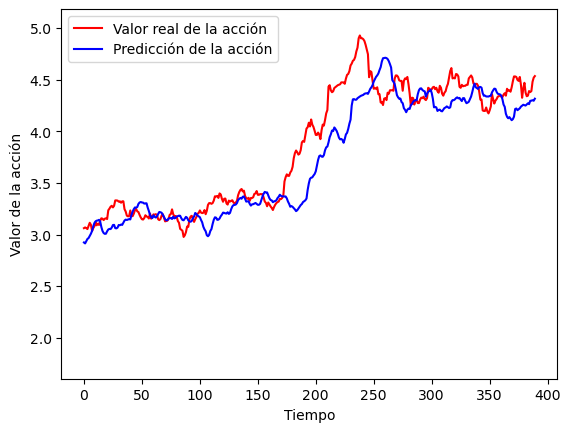

In [38]:
graficar_predicciones(valores_reales[:],predicciones[:])

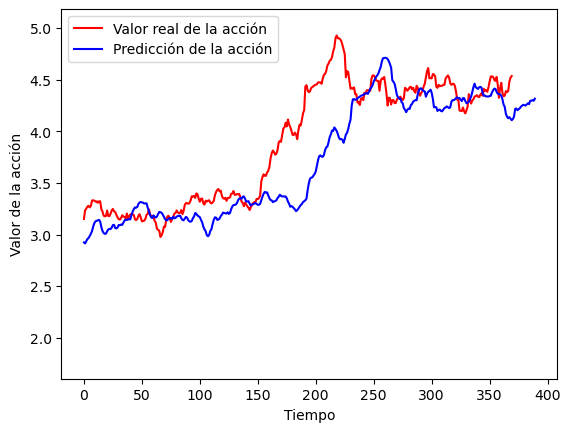

In [39]:
graficar_predicciones(valores_reales[num_dias_pred:],predicciones[:])

Este gráfico representa lo que se habría ganado (rojo) o perdido (verde) si se considera que se compró por lo predicho y se vendió por lo real

In [40]:
import plotly.graph_objects as go

# Aquí asumo que tienes un DataFrame llamado 'df' con el índice 'Date' y las columnas 'Open', 'High', 'Low' y 'Close'
fig = go.Figure(data=[go.Candlestick(x=list(range(0,len(predicciones))),
                                     open=predicciones[:],
                                     high=predicciones[:],
                                     low=valores_reales[:],
                                     close=valores_reales[:])])
fig.show()

# https://github.com/codificandobits/Prediccion_de_acciones_en_la_bolsa_con_redes_LSTM/blob/master/prediccion_de_acciones.py

Beneficio de las transacciones alcistas:

(Lo que se gana si la predicción es de subida de un 7%, se compra al precio del día y se vende a los 10 días)

Compra: Se realiza cuando la predicción de la acción es al menos un 7% mayor que el precio real del día.

Venta: Se asume que se venderá la acción después de num_dias_pred días, y se calcula el beneficio comparando el precio real dentro de esos días con el precio de compra.

In [41]:
beneficio = 0
transacciones = 0
for indice, (hoy, prediccion) in enumerate(zip(valores_reales, predicciones)):
  if prediccion > 1.07*(hoy) and len(valores_reales)>indice + num_dias_pred: #no se intentará acceder a un índice fuera del rango de valores_reales y predicciones, ya que se necesita información de los valores futuros de valores_reales para hacer el cálculo del beneficio
    beneficio = beneficio + (valores_reales[indice + num_dias_pred] - hoy)
    print(f"Día {indice}: Valor real dentro de 10 días {valores_reales[indice + num_dias_pred]:.2f}, valor real hoy {hoy:.2f}. Beneficio: {valores_reales[indice + num_dias_pred] - hoy:.2f}")
    transacciones +=1
print(f"Beneficio total: {beneficio:.2f}€, número de transacciones realizadas: {transacciones}, beneficio medio por transacción {beneficio/transacciones:.2f}€")

Día 256: Valor real dentro de 10 días 4.49, valor real hoy 4.28. Beneficio: 0.21
Día 257: Valor real dentro de 10 días 4.51, valor real hoy 4.28. Beneficio: 0.23
Día 258: Valor real dentro de 10 días 4.51, valor real hoy 4.25. Beneficio: 0.25
Día 259: Valor real dentro de 10 días 4.53, valor real hoy 4.32. Beneficio: 0.21
Día 260: Valor real dentro de 10 días 4.46, valor real hoy 4.32. Beneficio: 0.13
Día 261: Valor real dentro de 10 días 4.36, valor real hoy 4.30. Beneficio: 0.06
Día 262: Valor real dentro de 10 días 4.25, valor real hoy 4.37. Beneficio: -0.12
Día 263: Valor real dentro de 10 días 4.33, valor real hoy 4.36. Beneficio: -0.04
Beneficio total: 0.94€, número de transacciones realizadas: 8, beneficio medio por transacción 0.12€


Beneficio de las transacciones bajistas:

(Lo que se gana si la predicción es de bajada de un 7%, se vende al precio del día y se compra a los 10 días)

In [42]:
beneficio = 0
transacciones = 0
for indice, (hoy, prediccion) in enumerate(zip(valores_reales, predicciones)):
  if prediccion < 0.93*(hoy) and len(valores_reales)>indice + num_dias_pred:
    beneficio = beneficio - (valores_reales[indice + num_dias_pred] - hoy)
    print(f"Día {indice}: Valor real dentro de 10 días {valores_reales[indice + num_dias_pred]:.2f}, valor real hoy {hoy:.2f}. Beneficio: {hoy - valores_reales[indice + num_dias_pred]:.2f}")
    transacciones +=1
print(f"Beneficio total: {beneficio:.2f}€, número de transacciones realizadas: {transacciones}, beneficio medio por transacción {beneficio/transacciones:.2f}€")

Día 27: Valor real dentro de 10 días 3.22, valor real hoy 3.33. Beneficio: 0.11
Día 28: Valor real dentro de 10 días 3.19, valor real hoy 3.33. Beneficio: 0.14
Día 29: Valor real dentro de 10 días 3.17, valor real hoy 3.33. Beneficio: 0.16
Día 106: Valor real dentro de 10 días 3.32, valor real hoy 3.23. Beneficio: -0.09
Día 107: Valor real dentro de 10 días 3.33, valor real hoy 3.29. Beneficio: -0.04
Día 108: Valor real dentro de 10 días 3.33, valor real hoy 3.30. Beneficio: -0.03
Día 109: Valor real dentro de 10 días 3.31, valor real hoy 3.30. Beneficio: -0.01
Día 110: Valor real dentro de 10 días 3.30, valor real hoy 3.30. Beneficio: -0.00
Día 117: Valor real dentro de 10 días 3.42, valor real hoy 3.40. Beneficio: -0.02
Día 177: Valor real dentro de 10 días 4.06, valor real hoy 3.57. Beneficio: -0.50
Día 178: Valor real dentro de 10 días 4.04, valor real hoy 3.60. Beneficio: -0.44
Día 179: Valor real dentro de 10 días 4.01, valor real hoy 3.62. Beneficio: -0.39
Día 180: Valor real de

In [43]:
ultimas_cotiz = dataset[-time_step:].iloc[:,1:2] # ultimos 100 dias
ultimas_cotiz_escalado = sc.transform(ultimas_cotiz)
np.array(ultimas_cotiz_escalado).shape

(100, 1)

In [44]:
array_repetido = np.repeat(np.array(ultimas_cotiz_escalado), num_dias_pred, axis=1).reshape(1, time_step, num_dias_pred)

In [45]:
array_repetido.shape

(1, 100, 20)

In [ ]:
ultima_prediccion = modelo.predict(array_repetido) 
# La salida es una predicción del valor de la acción para los proximos 20 días
ultima_prediccion = sc.inverse_transform(ultima_prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [47]:
print(ultima_prediccion[0])

[4.4709053 4.44803   4.4848127 4.4996123 4.4887834 4.4750385 4.475847
 4.479608  4.514676  4.4566703 4.4464602 4.4778857 4.4707284 4.4841537
 4.460556  4.4507484 4.457267  4.4617753 4.435836  4.396438 ]


In [48]:
predicho = ultima_prediccion[0][num_dias_pred-1]
print(predicho)

4.396438


In [49]:
ultimo = ultimas_cotiz["High"].tolist()[-1] #el valor más alto de la última cotización de la acción
print(ultimo)

4.5


In [50]:
print(f"Porcentaje predicho para dentro de {num_dias_pred} días: {100*(predicho-ultimo)/ultimo}%") #porcentaje de cambio
if 100*(predicho-ultimo)/ultimo > 10: #si el modelo predice que el precio aumentará más del 10% en los próximos 20 dias, me imprime el mensaje
  print("¡Compra insensato!")

Porcentaje predicho para dentro de 20 días: -2.301375071207682%
